In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bing_helper import load_json_files, get_hits_from_json, load_lang_news_hits
from regression import fit_regression_and_rename_coeffs_by_cat, fit_regression_and_rename_coeffs, write_reg_results
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results, plot_regression_results_interactions, plot_country_counts, plot_regression_results_interactions_from_dict, plot_cat_by_cat_variable
from preprocessing import load_if_in_country_or_lang
from steinkasserer.preprocessing import categorize_views_for_df

%load_ext autoreload
%autoreload 2

/home/ruptho/.local/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## load Data


In [2]:
df_crawled = load_preprocessed_events()
df_crawled = load_if_in_country_or_lang(df_crawled)
data = build_regression_dataframe(df_crawled)
df_crawled.head()

/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,population,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,203631356,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,329484123,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,1380004385,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,97338583,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,10093121,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False


In [3]:
df_crawled = categorize_views_for_df(df_crawled)

In [4]:
df_crawled.head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False,>10^7
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False,>10^8
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False,>10^7
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False,>10^6


# Poisson regression, Quasi-regression model, Non-negative binomial model
https://www.youtube.com/watch?v=jnKDQtDy0Bg

https://www.youtube.com/watch?v=uGKnoAw-PFQ

In [5]:
from processing import compute_mean_and_variance
import statsmodels.api as sm
from plot_regression import plot_pearson_residuals

In [6]:
# excluding all articles that have no category or less than 10 recorded views in the week after the event happened
df_filtered = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.views_7_sum > 10)]
data_filtered = build_regression_dataframe(df_filtered)

/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='mean', ylabel='var'>

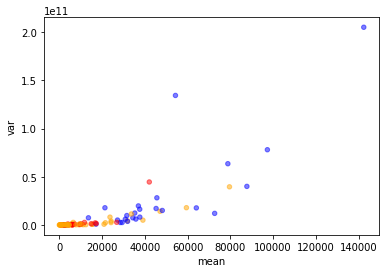

In [7]:
# mean-variance plot suggests to use negative binomial model! this is supported by poisson regression below (deviance >>>> DoF, very small error bars)
mean_var = compute_mean_and_variance(df_filtered, ['code', 'gni_region', 'cat'])['views_7_sum']
col_map = {'de': 'orange', 'en': 'blue', 'es': 'red', 'it': 'orange'}
col = [col_map[var[0]] for var in mean_var.index]
mean_var.plot.scatter(x='mean', y='var', color=col, alpha=0.5)

In [8]:
compute_mean_and_variance(df_filtered, ['code', 'gni_region', 'cat'])['views_7_sum']

mean           var
code gni_region            cat                                 
de   East Asia & Pacific   culture     266.333333  3.605733e+04
                           disaster  15254.400000  5.976131e+08
                           politics   5466.906250  3.057974e+07
                           sports     2646.382514  5.694921e+07
     Europe & Central Asia culture   11182.569620  1.937942e+08
...                                           ...           ...
it   South Asia            politics     69.500000  6.844500e+03
                           sports     1137.000000  1.630818e+06
     Sub-Saharan Africa    disaster   2054.666667  1.383099e+07
                           politics    292.928571  1.095870e+05
                           sports    10393.000000  5.819687e+08

[103 rows x 2 columns]

In [9]:
compute_mean_and_variance(df_filtered, 'gni_class')

views_7_sum              
                   mean           var
gni_class                            
H          25927.824198  2.182053e+10
L          26345.761194  4.042424e+09
LM         27390.089691  7.568149e+09
UM         23020.099937  1.482262e+10

### Poisson Regression

In [10]:
df_code = df_filtered[df_filtered.code == 'en']

In [11]:
model_ps = sm.GLM.from_formula('views_7_sum ~ cat * gni_class', family=sm.families.Poisson(), data=df_code).fit()
model_ps.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Generalized linear model
==================================================================================
Model:                    GLM                  AIC:                1080169578.9799
Link Function:            Log                  BIC:                1080023249.6438
Dependent Variable:       views_7_sum          Log-Likelihood:     -5.4008e+08    
Date:                     2022-03-07 09:46     LL-Null:            -5.6871e+08    
No. Observations:         7606                 Deviance:           1.0801e+09     
Df Model:                 15                   Pearson chi2:       5.62e+09       
Df Residuals:             7590                 Scale:              1.0000         
Method:                   IRLS                                                    
----------------------------------------------------------------------------------
                                 Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                       10.8004   0.0002 55268.8111 0.0000 10.8000 10.8008
cat[T.disaster]                  0.8605   0.0002  3494.3627 0.0000  0.8601  0.8610
cat[T.politics]                 -0.0793   0.0002  -346.0216 0.0000 -0.0797 -0.0788
cat[T.sports]                   -0.5643   0.0002 -2509.2747 0.0000 -0.5648 -0.5639
gni_class[T.L]                  -5.5927   0.0427  -130.9206 0.0000 -5.6764 -5.5090
gni_class[T.LM]                 -1.2597   0.0011 -1142.1850 0.0000 -1.2619 -1.2575
gni_class[T.UM]                 -0.6622   0.0009  -727.2578 0.0000 -0.6639 -0.6604
cat[T.disaster]:gni_class[T.L]   4.8507   0.0427   113.5442 0.0000  4.7670  4.9345
cat[T.politics]:gni_class[T.L]   5.1794   0.0427   121.2210 0.0000  5.0956  5.2631
cat[T.sports]:gni_class[T.L]     5.2208   0.0428   121.9968 0.0000  5.1369  5.3047
cat[T.disaster]:gni_class[T.LM]  0.5310   0.0012   458.0111 0.0000  0.5287  0.5332
cat[T.politics]:gni_class[T.LM]  1.0222   0.0012   872.8715 0.0000  1.0199  1.0245
cat[T.sports]:gni_class[T.LM]    1.4242   0.0012  1213.6062 0.0000  1.4219  1.4265
cat[T.disaster]:gni_class[T.UM]  0.0746   0.0010    76.7500 0.0000  0.0727  0.0765
cat[T.politics]:gni_class[T.UM]  0.2651   0.0010   269.9097 0.0000  0.2632  0.2671
cat[T.sports]:gni_class[T.UM]    0.9450   0.0009  1013.8470 0.0000  0.9432  0.9468
==================================================================================

"""

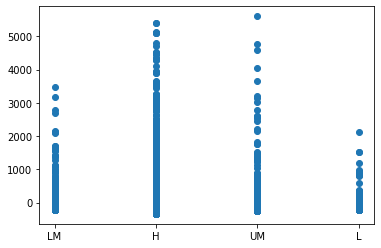

In [12]:
resid_outliers = model_ps.resid_pearson.nlargest(15)
outlier_filter = ~model_ps.resid_pearson.isin(resid_outliers)
plt.scatter(df_code.loc[outlier_filter, :].gni_class, model_ps.resid_pearson[outlier_filter])

In [13]:
# compute dispersion: ssqpearsonres / degrees of freedom

In [14]:
sum(np.square(model_ps.resid_pearson)) / model_ps.df_model

374400581.5530272

## Negative Binomial

In [ ]:
model_neg_f = sm.GLM.from_formula('views_7_sum ~ cat * gni_region * code', family=sm.families.NegativeBinomial(),
                                  data=df_filtered)
model_neg = model_neg_f.fit()
model_neg.summary()

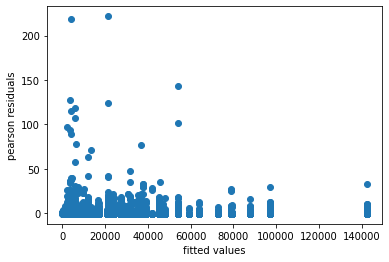

In [37]:
plot_pearson_residuals(df_filtered, model_neg, 0, None)

In [36]:
model_neg.fittedvalues

0         64097.621202
1        142457.853242
2         64097.621202
3         13612.887115
4         97346.746817
             ...      
14913     37620.766062
14914     27227.301598
14915     27227.301598
14916      4303.655272
14917      5874.475426
Length: 14801, dtype: float64

/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


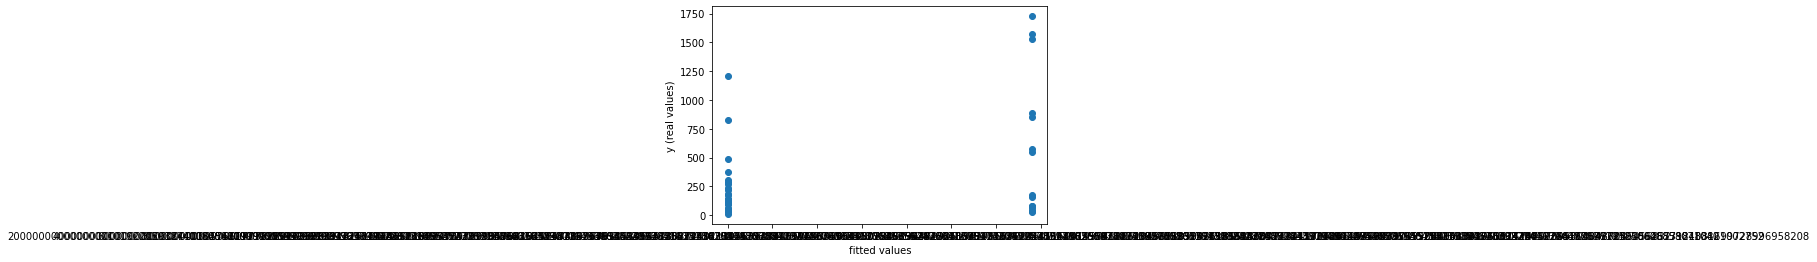

In [90]:
from steinkasserer.plot_regression import plot_real_vs_fitted

plot_real_vs_fitted(df_filtered, model_neg, log_scale=False)

In [50]:
df_filtered['fitted'] = model_neg.fittedvalues

/tmp/ipykernel_4911/2546756375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['fitted'] = model_neg.fittedvalues


In [74]:
df_filtered[(df_filtered.views_7_sum > (model_neg.fittedvalues * 20)) & (df_filtered.views_7_sum > 2*10**6)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat,fitted
229,Q170645,2018 FIFA World Cup,2018-06-14,Global North,Russia,Europe,sports,"['Category:2017–18 in Russian football', 'Cate...",4756233,188749.000000,...,2018,11372.277988,1.657328e+12,False,2018-06-01,6.418600e+07,False,False,>10^7,21338.125992
384,Q189571,UEFA Euro 2016,2016-06-10,Global North,France,Europe,sports,"['Category:2015–16 in French football', 'Categ...",2663535,118587.428571,...,2016,36979.702257,2.471286e+12,True,2016-06-01,9.501500e+07,False,False,>10^7,21338.125992
466,Q20022969,88th Academy Awards,2016-02-28,Global North,United States,North America,culture,"['Category:2015 film awards', 'Category:2016 a...",2095840,53235.857143,...,2016,57876.719077,1.869511e+13,True,2016-02-01,3.429789e+09,True,True,>10^9,78854.422721
736,Q21479779,November 2015 Paris attacks,2015-11-13,Global North,France,Europe,disaster,"['Category:10th arrondissement of Paris', 'Cat...",2931843,0.000000,...,2015,36611.753912,2.438208e+12,True,2015-11-01,9.531800e+07,False,False,>10^7,97346.746817
945,Q22076019,89th Academy Awards,2017-02-26,Global North,United States,North America,culture,"['Category:2016 film awards', 'Category:2017 a...",2013088,49717.000000,...,2017,59921.674703,1.947962e+13,True,2017-02-01,3.313535e+09,True,True,>10^9,78854.422721
1117,Q22923830,2020 United States presidential election,2020-11-03,Global North,United States,North America,politics,['Category:2020 United States presidential ele...,7847440,186775.857143,...,2020,63122.594145,2.089375e+13,True,2020-11-01,3.137752e+09,True,True,>10^9,54331.563062
4408,Q47496499,92nd Academy Awards,2020-02-09,Global North,United States,North America,culture,"['Category:2019 film awards', 'Category:2020 a...",2226447,53921.428571,...,2020,63122.594145,2.089375e+13,True,2020-02-01,3.297605e+09,True,True,>10^9,78854.422721
6833,Q699872,2016 United States presidential election,2016-11-08,Global North,United States,North America,politics,['Category:2016 United States presidential ele...,5580333,108.714286,...,2016,57876.719077,1.869511e+13,True,2016-11-01,3.132468e+09,True,True,>10^9,54331.563062
7369,Q8613,2016 Summer Olympics,2016-08-05,Global South,Brazil,South America,sports,"['Category:2010s in Rio de Janeiro', 'Category...",2866833,112068.571429,...,2016,8710.063417,1.795693e+12,False,2016-08-01,6.046900e+07,False,False,>10^7,36988.382921
7426,Q95579249,Murder of George Floyd,2020-05-25,Global North,United States,North America,disaster,"['Category:2020 controversies', 'Category:2020...",4748626,0.000000,...,2020,63122.594145,2.089375e+13,True,2020-05-01,3.455160e+09,True,True,>10^9,142457.853242


In [84]:
df_filtered.fitted.max()

142457.85324154526

In [85]:
df_filtered[df_filtered.fitted > (12 * 10**4)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat,fitted
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.0,...,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9,142457.853242
14,Q100804527,October 2020 Alaska Peninsula earthquake,2020-10-19,Global North,United States,North America,disaster,['Category:Redirects from merges'],2230,0.0,...,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9,142457.853242
39,Q101072249,Quebec City stabbing,2020-10-31,Global North,Canada,North America,disaster,"['Category:2020 in Quebec', 'Category:2020 mur...",6635,0.0,...,2020,43559.710092,1.644037e+12,True,2020-10-01,3.592780e+08,True,False,>10^8,142457.853242
70,Q104215553,Kenosha unrest shooting,2020-08-25,Global North,United States,North America,disaster,['Category:2020 controversies in the United St...,33248,0.0,...,2020,63122.594145,2.089375e+13,True,2020-08-01,3.455160e+09,True,True,>10^9,142457.853242
76,Q104511862,2020 Nashville bombing,2020-12-25,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",568610,0.0,...,2020,63122.594145,2.089375e+13,True,2020-12-01,3.166022e+09,True,True,>10^9,142457.853242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Q96396444,Northern Arizona University shooting,2015-10-09,Global North,United States,North America,disaster,"['Category:2015 in Arizona', 'Category:2015 ma...",38,0.0,...,2015,56738.091771,1.820602e+13,True,2015-10-01,3.431834e+09,True,True,>10^9,142457.853242
7520,Q97357872,Reactions to the murder of George Floyd,2020-05-25,Global North,United States,North America,disaster,['Category:Aftermath of the George Floyd prote...,11,0.0,...,2020,63122.594145,2.089375e+13,True,2020-05-01,3.455160e+09,True,True,>10^9,142457.853242
7579,Q98605503,Shooting of Jacob Blake,2020-08-23,Global North,United States,North America,disaster,['Category:2020 controversies in the United St...,1285795,0.0,...,2020,63122.594145,2.089375e+13,True,2020-08-01,3.455160e+09,True,True,>10^9,142457.853242
7589,Q98800012,Shooting of Cannon Hinnant,2020-08-09,Global North,United States,North America,disaster,"['Category:2020 in North Carolina', 'Category:...",7076,0.0,...,2020,63122.594145,2.089375e+13,True,2020-08-01,3.455160e+09,True,True,>10^9,142457.853242


In [ ]:
142457

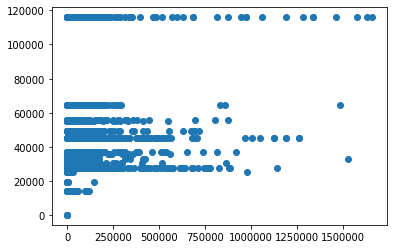

In [18]:
resid_outliers = model_ps.resid_pearson.nlargest(10)
outlier_filter = ~model_ps.resid_pearson.isin(resid_outliers)
fig, ax = plt.subplots()
ax.scatter(df_code.loc[outlier_filter, :].views_7_sum, model_ps.fittedvalues[outlier_filter])
ax.ticklabel_format(style='plain')

<AxesSubplot:ylabel='Frequency'>

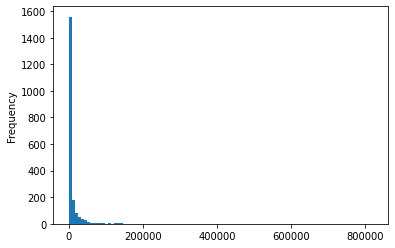

In [19]:
df_filtered[df_filtered.code == 'de'].views_7_sum.plot.hist(bins=100)

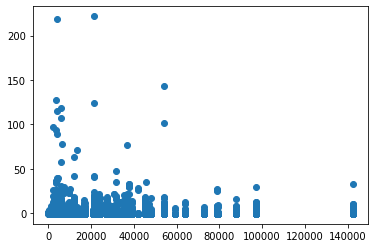

In [20]:
plt.scatter(model_neg.fittedvalues, model_neg.resid_pearson)

# Visualization

In [ ]:
df_filtered.groupby(['code', 'cat', 'gni_class']).size()

In [ ]:
df_filtered.nlargest(10, 'views_7_sum')

In [ ]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                               formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America'))",
                                                               type='poisson')

fig_int_region_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                       results_fit_separate, ['cat:gni_region'],
                                                                       {'gni_class': 'H', 'in_code_lang': True,
                                                                        'gni_region': 'North America', 'cat': 'sports',
                                                                        'code': 'en'},
                                                                       label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                   'cat': ['sports', 'disaster',
                                                                                           'culture', 'politics'],
                                                                                   'gni_region': ['North America',
                                                                                                  'Europe & Central Asia',
                                                                                                  'Middle East & North Africa',
                                                                                                  'East Asia & Pacific',
                                                                                                  'South Asia',
                                                                                                  'Latin America & Caribbean',
                                                                                                  'Sub-Saharan Africa']},
                                                                       cat_dict={'en': 'English', 'it': 'Italian',
                                                                                 'es': 'Spanish', 'de': 'German'},
                                                                       title='views ~ gni_class * class (separate)',
                                                                       label_rename_dict={
                                                                           'Middle East & North Africa': 'MENAf',
                                                                           'Latin America & Caribbean': 'LatAmC',
                                                                           'Europe & Central Asia': 'EuCAs',
                                                                           'East Asia & Pacific': 'EAsP',
                                                                           'North America': 'NAm',
                                                                           'Sub-Saharan Africa': 'SSAf',
                                                                           'South Asia': 'SAs'},
                                                                       figsize=(13, 22), x_limits=(-6.5, 3),
                                                                       include_counts=True)

In [ ]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_class_control = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                             formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) + np.log1p(views_baseline)",
                                                                             type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class_control,
                                                                      ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class_control.pdf')

In [ ]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_class_controlcat = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                             formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) + C(views_baseline_cat, Treatment(reference='>10^8'))",
                                                                             type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class_controlcat,
                                                                      ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class_controlcat.pdf')

In [ ]:
results_fit_separate_class = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                     formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H'))",
                                                                     type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class, ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class.pdf')

In [ ]:
results_fit_separate_class['en'].summary()

In [ ]:
results_fit_separate_region = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America'))",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region.pdf')

In [ ]:
df_filtered.views_baseline_cat.value_counts()

In [ ]:
results_fit_separate_region = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America')) + np.log1p(views_baseline)",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region_control.pdf')

In [ ]:
results_fit_separate_class['en'].summary()

In [ ]:
df_filtered.views_baseline_cat.value_counts()>10^9

In [ ]:
results_fit_separate_region_controlcat = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America')) + C(views_baseline_cat, Treatment(reference='>10^8'))",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region_controlcat, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region_controlcat.pdf')

In [ ]:
results_fit_separate_region['de'].summary2()

In [ ]:
results_fit_separate_region['de']

In [ ]:
 results_fit_separate_region['de'].summary()

In [ ]:
#fig.subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['de'], title='de', ax=axs[0])
plot_pearson_residuals(df_filtered[df_filtered.code == 'en'], results_fit_separate_region['en'], title='en', ax=axs[1])
plot_pearson_residuals(df_filtered[df_filtered.code == 'es'], results_fit_separate_region['es'], title='es', ax=axs[2])
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['it'], title='it', ax=axs[3])
fig.tight_layout()

In [ ]:
#fig.subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['de'], exclude_n_outliers=10,
                       title='de', ax=axs[0])
plot_pearson_residuals(df_filtered[df_filtered.code == 'en'], results_fit_separate_region['en'], exclude_n_outliers=10,
                       title='en', ax=axs[1])
plot_pearson_residuals(df_filtered[df_filtered.code == 'es'], results_fit_separate_region['es'], exclude_n_outliers=10,
                       title='es', ax=axs[2])
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['it'], exclude_n_outliers=10,
                       title='it', ax=axs[3])
fig.tight_layout()

In [ ]:
from plot_regression import compute_regression_outliers_from_residual

resid_outliers, outlier_filter = {}, {}
for code in ['de', 'it', 'es', 'en']:
    resid_outliers[code], outlier_filter[code] = compute_regression_outliers_from_residual(
        results_fit_separate_region[code])
all_outliers = pd.concat(resid_outliers.values())
all_filters = ~df_filtered.index.isin(all_outliers.index)

In [ ]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_region_filtered = fit_regression_and_rename_coeffs_by_cat(df_filtered.loc[all_filters, :],
                                                                               formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H'))",
                                                                               type='nb')

fig_int_class_cat_nb_filtered = plot_regression_results_interactions_from_dict(df_filtered.loc[all_filters, :],
                                                                               results_fit_separate_region_filtered,
                                                                               ['cat:gni_class'],
                                                                               {'gni_class': 'H', 'in_code_lang': True,
                                                                                'gni_region': 'North America',
                                                                                'cat': 'sports', 'code': 'en'},
                                                                               label_sort={
                                                                                   'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                   'cat': ['sports', 'disaster',
                                                                                           'culture', 'politics'],
                                                                                   'gni_region': ['North America',
                                                                                                  'Europe & Central Asia',
                                                                                                  'Middle East & North Africa',
                                                                                                  'East Asia & Pacific',
                                                                                                  'South Asia',
                                                                                                  'Latin America & Caribbean',
                                                                                                  'Sub-Saharan Africa']},
                                                                               cat_dict={'en': 'English',
                                                                                         'it': 'Italian',
                                                                                         'es': 'Spanish',
                                                                                         'de': 'German'},
                                                                               title='views ~ gni_class * class (separate)',
                                                                               label_rename_dict={
                                                                                   'Middle East & North Africa': 'MENAf',
                                                                                   'Latin America & Caribbean': 'LatAmC',
                                                                                   'Europe & Central Asia': 'EuCAs',
                                                                                   'East Asia & Pacific': 'EAsP',
                                                                                   'North America': 'NAm',
                                                                                   'Sub-Saharan Africa': 'SSAf',
                                                                                   'South Asia': 'SAs'},
                                                                               figsize=(12, 14), x_limits=(-6.5, 3),
                                                                               include_counts=True)

In [ ]:
df_filtered.views_baseline_cat.value_counts()>10^9

In [ ]:
results_fit_separate_class_controlcat['en'].summary()

In [ ]:
df_filtered.groupby(['code', 'views_baseline_cat']).count()

In [ ]:
## Try out views parameter

In [ ]:
from steinkasserer.regression import fit_negative_binomial_regression_and_rename_coeffs

results_nb = fit_negative_binomial_regression_and_rename_coeffs(df_filtered,
                                                                formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) * C(code, Treatment(reference='en')) + np.log1p(views_baseline) + in_code_lang")
results_nb_base = fit_negative_binomial_regression_and_rename_coeffs(df_filtered,
                                                                     formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(code, Treatment(reference='en'))")
results_nb.summary()

In [ ]:
df_filtered

In [ ]:
df_filtered

In [ ]:
np.sum(np.square(results_nb.resid_pearson)) / results_nb.df_resid